# Applied Time Series - Lesson 1: Basic

I will work on time series analysis on following notebooks to learn concepts and apply them in simple datasets so we can build a more robust analysis for future jobs. Here I will start lesson one in https://online.stat.psu.edu/stat510/lesson/1/1.1 course.

In [121]:
import sys
import logging

sys.path.append("../src/")

from utils import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklego.pandas_utils import log_step


%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Lesson 1: Overview of Time Series Characteristics

The first dataset is historical climate data from the city of Sao Paulo.

In [123]:
df_climate_sp = (
                 pd.read_csv("../data/raw/station_sao_paulo.csv")
                   .rename(columns=str.lower)
                   .pipe(get_only_month_columns)
                   .pipe(remove_inconsistencies)
                  # .set_index('year')
                   .melt(id_vars='year',
                         var_name='month',
                         value_name='temperature')
                   .assign(date=lambda x: pd.to_datetime(x['year'].astype(str) + '-' + x['month']))
                   .drop(['year', 'month'], axis=1)
                   .set_index('date')
                   .copy()
)

df_climate_sp.head(10)

INFO:__main__:[get_only_month_columns(df)] n_obs=74 n_col=13 time=0:00:00.002541
INFO:__main__:[remove_inconsistencies(df)] n_obs=74 n_col=13 time=0:00:00.040040


,temperature
date,
1946-01-01,23.735
1947-01-01,23.735
1948-01-01,23.640
1949-01-01,22.340
1950-01-01,22.140
1951-01-01,22.040
1952-01-01,22.640
1953-01-01,23.740
1954-01-01,24.240


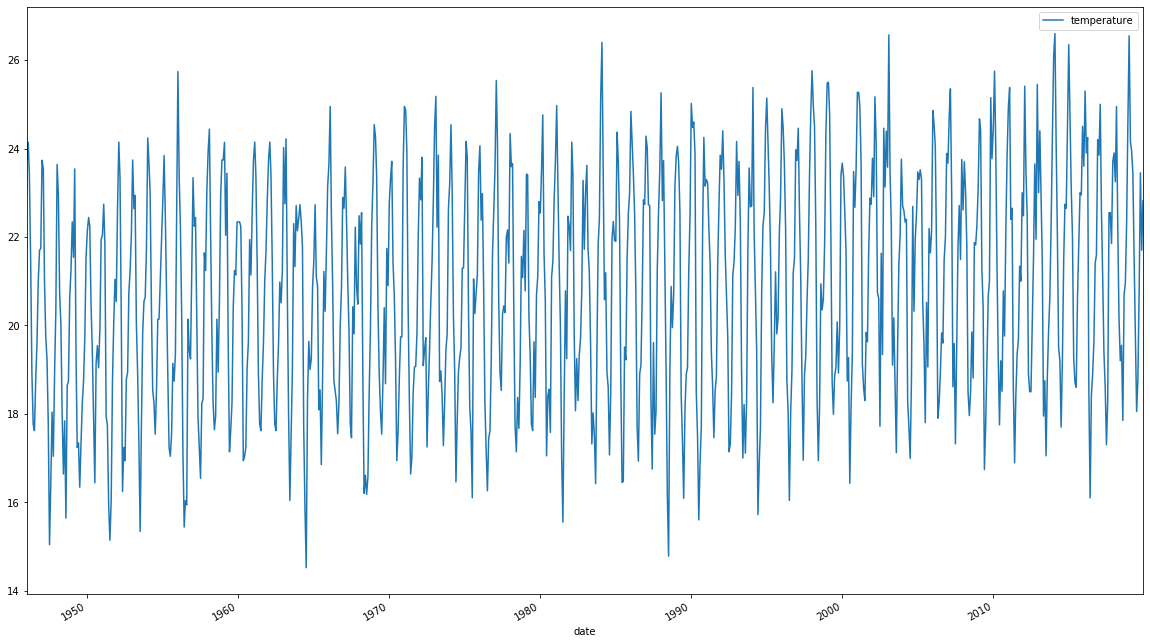

In [124]:
df_climate_sp.plot(figsize=(20, 12))

### Climate Data

Characteristics to consider first:

- There is a small positive linear trend.
- There is a strong **seasonality** factor. From above plot it is likely an annual seasonal factor.
- No apparent **outliers**
- No long-run **cycle**
- Since this is a well behaved time series, the **variance seems constant** over time.
- No **abrupt changes**

Before starting prototyping a model, let's see the series lagged scatter plot.

In [125]:
def compute_lag_features(df, lags, col=None):
    for lag in range(1, lags):
        if not col:
            df.loc[:, 'lag_' + str(lag)] = df.shift(lag)
        else:
            df.loc[:, 'lag_' + str(lag)] = df[col].shift(lag)
        
    return df
df_climate_sp = compute_lag_features(df_climate_sp, 20)
df_climate_sp.head(10)

,temperature,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
date,,,,,,,,,,,,,,,,,,,,
1946-01-01,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-01-01,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-01-01,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-01-01,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-01,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951-01-01,22.040,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-01-01,22.640,22.040,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953-01-01,23.740,22.640,22.040,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-01-01,24.240,23.740,22.640,22.040,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


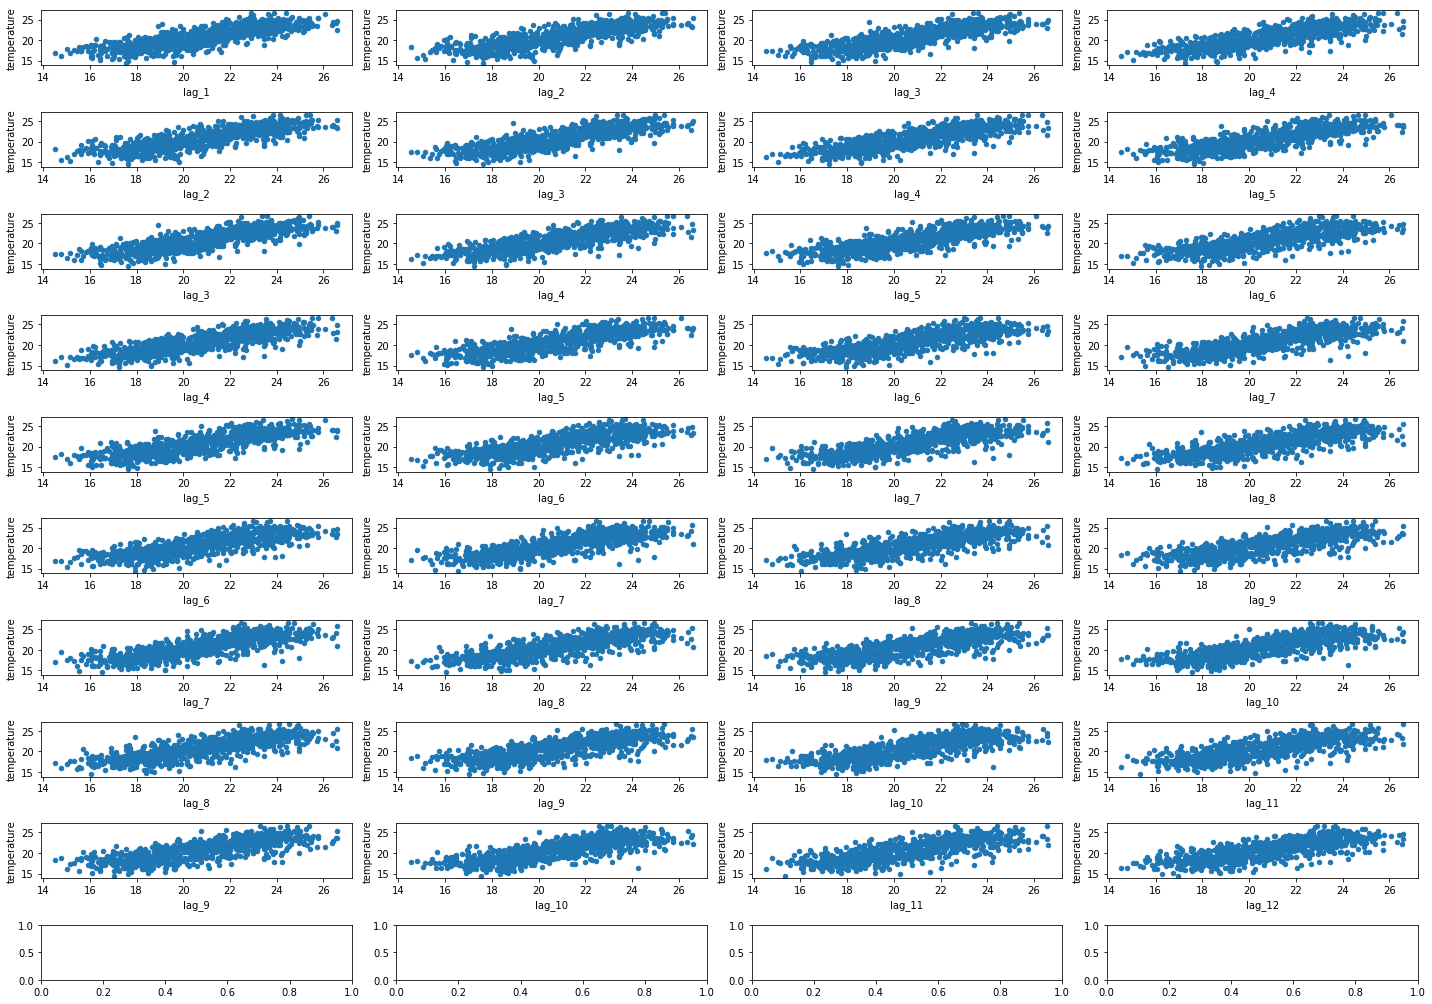

In [126]:
fig, axes = plt.subplots(10, 4, figsize=(20, 14))
for lag in range(1, 10):
    for j in range(4):
        df_climate_sp.plot(y='temperature',
                           x='lag_' + str(lag+j),
                          kind='scatter',
                          ax=axes[lag-1][j])
        
plt.tight_layout()

As we would imagine from the first plot, the series is highly correlated with its lag values, essentially the first ones. Now let's create a simple regression model considering the first lag only as a independent variable.

In [127]:
df_climate_sp.iloc[1:, :]

,temperature,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
date,,,,,,,,,,,,,,,,,,,,
1947-01-01,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-01-01,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-01-01,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-01,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951-01-01,22.040,22.140,22.340,23.640,23.735,23.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-01,24.500,24.550,24.250,25.450,23.000,23.820,23.77,22.25,23.75,23.89,22.13,22.51,23.76,24.39,22.74,23.54,23.41,24.33,24.82,23.97
2016-12-01,24.200,24.500,24.550,24.250,25.450,23.000,23.82,23.77,22.25,23.75,23.89,22.13,22.51,23.76,24.39,22.74,23.54,23.41,24.33,24.82
2017-12-01,23.700,24.200,24.500,24.550,24.250,25.450,23.00,23.82,23.77,22.25,23.75,23.89,22.13,22.51,23.76,24.39,22.74,23.54,23.41,24.33


In [128]:
import statsmodels.formula.api as smf

df_climate_sp = df_climate_sp.fillna(0)

lm = smf.ols("""temperature ~ lag_1 + 1""", 
             data = df_climate_sp.iloc[1:, :])

# We see the results:
model_climate = lm.fit()
summary = model_climate.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     1870.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):          1.83e-220
Time:                        10:57:19   Log-Likelihood:                -1573.8
No. Observations:                 887   AIC:                             3152.
Df Residuals:                     885   BIC:                             3161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6732      0.399      9.196      0.000       2.889       4.457
lag_1          0.8236      0.019     43.247      0.000       0.786       0.861
==============================================================================
Omnibus:                        2.337   Durbin-Watson:                   2.734
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.193
Skew:                          -0.113   Prob(JB):                        0.334
Kurtosis:                       3.090   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that our model performs reasonably well. We can define temperatura in the following day by the equation:

     temperature = 3.6732 + 0.8236*temperature_lag_1
     
Adj. R-squared:	0.679

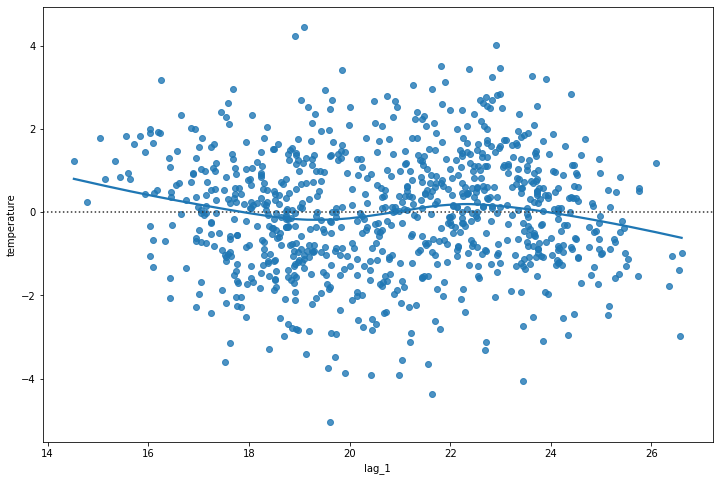

In [129]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x='lag_1', y='temperature', data=df_climate_sp.iloc[1:, :], lowess=True)

The residual plot shows, obviously, residuals for our model. We can see that we have seasonality factor influencing our errors, indicating that our model is not complete. We can use dummy variable for month to indicating the seasonality. Also, we talked about a little trend.

In [130]:
df_climate_sp = (
                 df_climate_sp.assign(month=df_climate_sp.index.month,
                                      trend=np.arange(df_climate_sp.shape[0]))
)

In [131]:
lm = smf.ols("""temperature ~ lag_1 + C(month) + trend + 1""", 
             data = df_climate_sp.iloc[1:, :])

# We see the results:
model_climate = lm.fit()
summary = model_climate.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     334.3
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:57:24   Log-Likelihood:                -1284.5
No. Observations:                 887   AIC:                             2597.
Df Residuals:                     873   BIC:                             2664.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.9351      0.754     30.424      0.000      21.456      24.415
C(month)[T.2]     -1.5854      0.213     -7.434      0.000      -2.004      -1.167
C(month)[T.3]     -4.2544      0.320    -13.303      0.000      -4.882      -3.627
C(month)[T.4]     -8.0110      0.465    -17.235      0.000      -8.923      -7.099
C(month)[T.5]    -12.4031      0.632    -19.623      0.000     -13.644     -11.163
C(month)[T.6]    -15.4055      0.778    -19.797      0.000     -16.933     -13.878
C(month)[T.7]    -17.6450      0.911    -19.362      0.000     -19.434     -15.856
C(month)[T.8]    -18.3721      1.019    -18.023      0.000     -20.373     -16.371
C(month)[T.9]    -19.2513      1.133    -16.999      0.000     -21.474     -17.029
C(month)[T.10]   -19.9157      1.244    -16.009      0.000     -22.357     -17.474
C(month)[T.11]   -20.9935      1.362    -15.410      0.000     -23.667     -18.320
C(month)[T.12]   -21.7237      1.478    -14.698      0.000     -24.625     -18.823
lag_1             -0.0069      0.032     -0.213      0.831      -0.071       0.057
trend              0.0255      0.002     14.277      0.000       0.022       0.029
==============================================================================
Omnibus:                        0.614   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.657
Skew:                           0.062   Prob(JB):                        0.720
Kurtosis:                       2.953   Cond. No.                     4.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

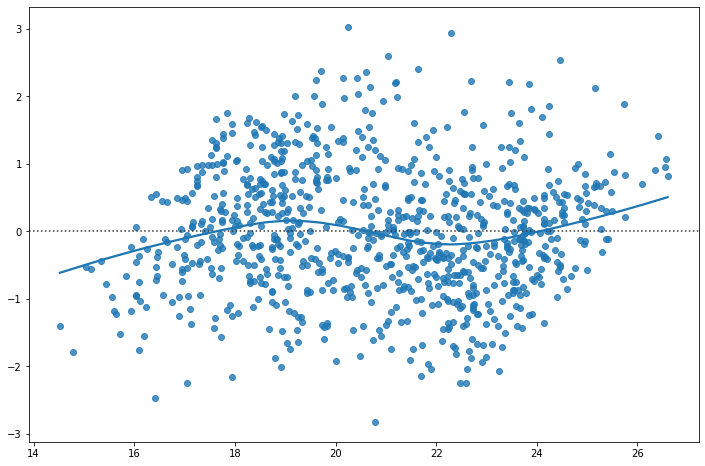

In [132]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x=df_climate_sp.iloc[1:, 0].values,
              y=model_climate.resid.values,
              lowess=True)

There is a remaining of correlated errors, we will treat more this database later.

### Arrivals Data

In [133]:
df_arrivals = (
                pd.read_csv('../data/raw/arrivals.csv')
                  .rename(columns={'Unnamed: 0': 'time'})
                  .set_index('time')
              )

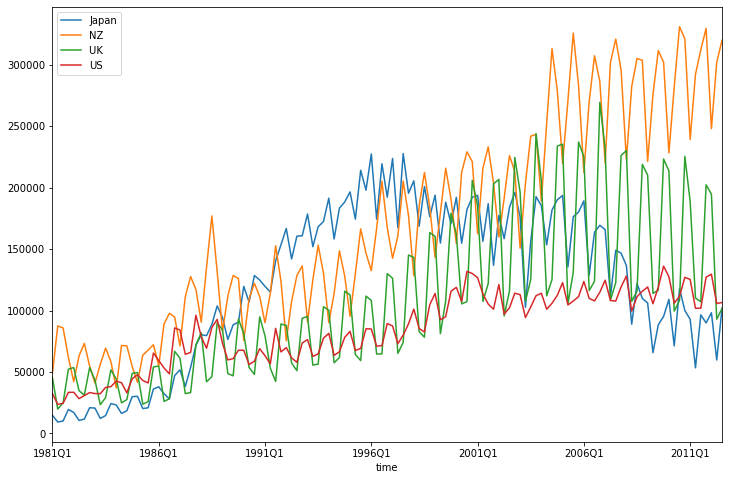

In [134]:
df_arrivals.plot(figsize=(12, 8))

Here, we have a dataset with trend and seasonality factors (Quaterly data). We will construct a regression model on top of that.

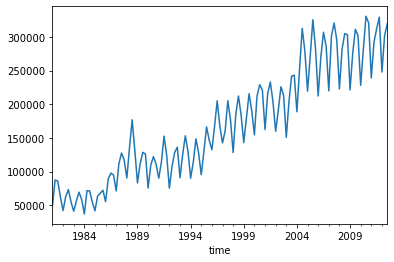

In [135]:
df_arrivals.index = pd.to_datetime(df_arrivals.index)
df_arrivals['NZ'].plot()

**Classical regression methods for trend and seasonal effects**

Following psu course, we will define the variables:

- For a linear trend, use  (the time index) as a predictor variable in a regression.
- For a quadratic trend, we might consider using both  and .
- For quarterly data, with possible seasonal (quarterly) effects, we can define indicator variables such as  if the observation is in quarter  of a year and 0 otherwise. There are 4 such indicators.

In [136]:
df_arrivals_nz = df_arrivals['NZ'].to_frame().copy()
df_arrivals_nz['time_variable'] = list(df_arrivals_nz.reset_index().index)
df_arrivals_nz['year_variable'] = df_arrivals_nz.index.year
df_arrivals_nz['quarter'] = df_arrivals_nz.index.quarter
df_arrivals_nz['n_arrivals'] = df_arrivals_nz['NZ']

In [137]:
df_arrivals_nz.head(10)

,NZ,time_variable,year_variable,quarter,n_arrivals
time,,,,,
1981-01-01,49140,0,1981,1,49140
1981-04-01,87467,1,1981,2,87467
1981-07-01,85841,2,1981,3,85841
1981-10-01,61882,3,1981,4,61882
1982-01-01,42045,4,1982,1,42045
1982-04-01,63081,5,1982,2,63081
1982-07-01,73275,6,1982,3,73275
1982-10-01,54808,7,1982,4,54808
1983-01-01,41030,8,1983,1,41030


In [138]:
lm = smf.ols("""n_arrivals ~ time_variable + C(quarter) - 1""", 
             data = df_arrivals_nz)

# We see the results:
model_arrivals = lm.fit()
summary = model_arrivals.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_arrivals   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     514.7
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           2.40e-75
Time:                        10:57:26   Log-Likelihood:                -1437.6
No. Observations:                 127   AIC:                             2885.
Df Residuals:                     122   BIC:                             2899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(quarter)[1]  -797.9608   4720.335     -0.169      0.866   -1.01e+04    8546.414
C(quarter)[2]  3.866e+04   4752.378      8.134      0.000    2.92e+04    4.81e+04
C(quarter)[3]  6.314e+04   4784.713     13.195      0.000    5.37e+04    7.26e+04
C(quarter)[4]  4.471e+04   4796.119      9.323      0.000    3.52e+04    5.42e+04
time_variable  2130.5447     49.277     43.236      0.000    2032.996    2228.094
==============================================================================
Omnibus:                        6.222   Durbin-Watson:                   0.719
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.332
Skew:                           0.545   Prob(JB):                       0.0422
Kurtosis:                       2.900   Cond. No.                         290.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
lm = smf.ols("""n_arrivals ~ year_variable + C(quarter) - 1""", 
             data = df_arrivals_nz)

# We see the results:
model = lm.fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_arrivals   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     514.7
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           2.40e-75
Time:                        10:57:26   Log-Likelihood:                -1437.6
No. Observations:                 127   AIC:                             2885.
Df Residuals:                     122   BIC:                             2899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(quarter)[1] -1.688e+07   3.94e+05    -42.900      0.000   -1.77e+07   -1.61e+07
C(quarter)[2] -1.684e+07   3.94e+05    -42.795      0.000   -1.76e+07   -1.61e+07
C(quarter)[3] -1.682e+07   3.94e+05    -42.727      0.000   -1.76e+07    -1.6e+07
C(quarter)[4] -1.683e+07   3.93e+05    -42.779      0.000   -1.76e+07   -1.61e+07
year_variable  8522.1789    197.109     43.236      0.000    8131.982    8912.376
==============================================================================
Omnibus:                        6.222   Durbin-Watson:                   0.719
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.332
Skew:                           0.545   Prob(JB):                       0.0422
Kurtosis:                       2.900   Cond. No.                     8.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

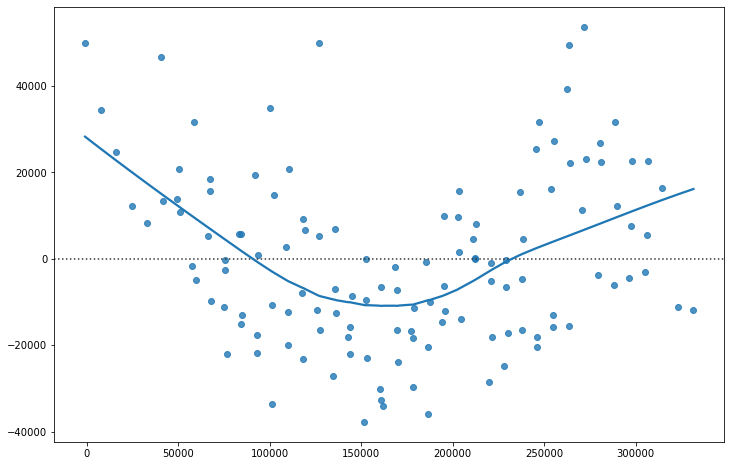

In [140]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x=model_arrivals.fittedvalues.values, y=model_arrivals.resid.values, lowess=True)

Here it is clear that we have serial correlation that our models is not taking into account. Probably for the seasonal variable.

Interesting to note is that when we use time as a trend variable, results are significant different for the coefficients. It might occurs that when we use year, we are not varying timestamps within a specific year, so the model balances what it gets from a trend (annual) discounted by quaterly effects.

### Autocorrelation Function (ACF)

Now, in order to check our assumptions about serial correlation of erros in the first (temperature data) and second (arrivals data) examples, we will use a autocorrelation function.

An ACF will plot the correlation between a x value at time t, with its lag values (t-1), (t-2), (t-3), etc. This is important, because if residuals are correlated somehow, we violate an important assumption a linear model that is uncorrelated errors. M(sigma, 0) ~ white noise.

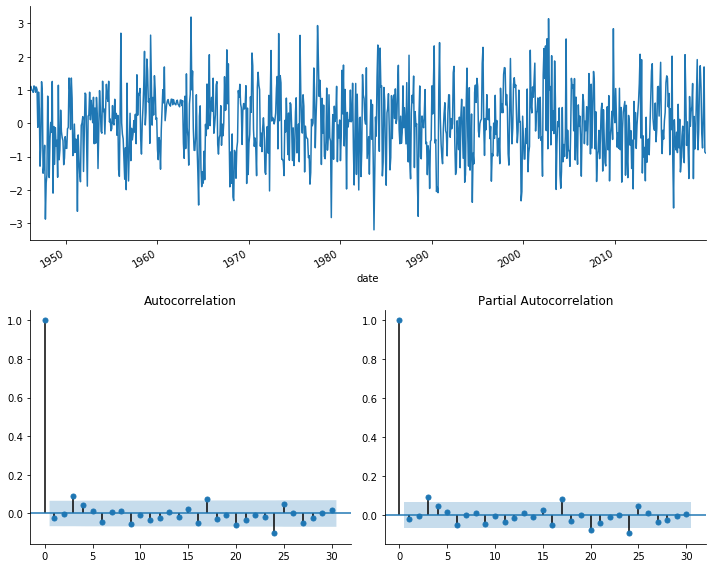

In [141]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(10, 8), **kargs):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, **kargs)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

tsplot(model_climate.resid);

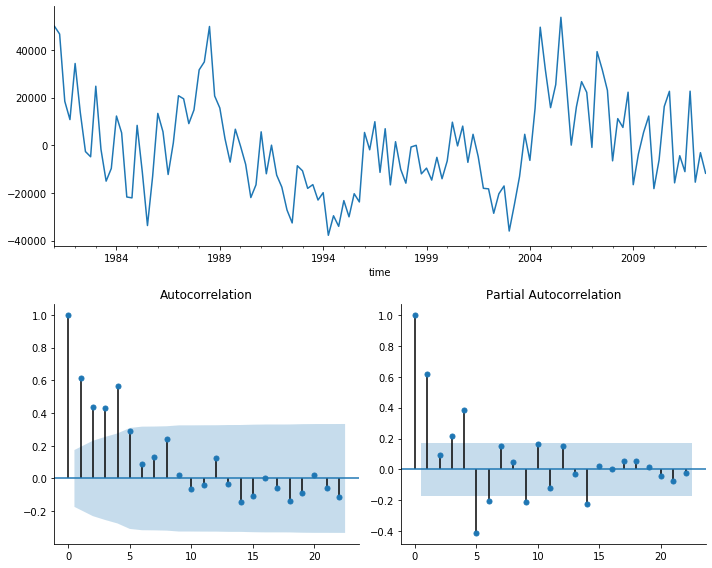

In [142]:
tsplot(model_arrivals.resid);

Significant coefficients for ACF plot of residuals for arrivals model shows a structural problem in our assumptions. We might improve model adding more lags into it, let's test.

In [143]:
df_arrivals_nz = compute_lag_features(df_arrivals_nz, 10, col='NZ')

In [144]:
lm = smf.ols("""n_arrivals ~ time_variable + C(quarter) +  lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 - 1""", 
             data=df_arrivals_nz)

# We see the results:
model_arrivals_more_lags = lm.fit()
summary = model_arrivals_more_lags.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             n_arrivals   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     396.8
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           2.88e-82
Time:                        10:57:31   Log-Likelihood:                -1270.5
No. Observations:                 118   AIC:                             2569.
Df Residuals:                     104   BIC:                             2608.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(quarter)[1] -5474.9746   5988.710     -0.914      0.363   -1.74e+04    6400.862
C(quarter)[2]  1.705e+04   5745.268      2.967      0.004    5654.411    2.84e+04
C(quarter)[3]  1.645e+04   5907.222      2.784      0.006    4731.785    2.82e+04
C(quarter)[4]  7607.1811   6018.837      1.264      0.209   -4328.398    1.95e+04
time_variable   626.8595    190.767      3.286      0.001     248.561    1005.158
lag_1             0.5246      0.095      5.511      0.000       0.336       0.713
lag_2             0.2512      0.106      2.361      0.020       0.040       0.462
lag_3            -0.1464      0.108     -1.355      0.178      -0.361       0.068
lag_4             0.4538      0.105      4.325      0.000       0.246       0.662
lag_5            -0.1471      0.113     -1.298      0.197      -0.372       0.078
lag_6            -0.3176      0.106     -3.001      0.003      -0.527      -0.108
lag_7             0.1122      0.111      1.008      0.316      -0.108       0.333
lag_8             0.2124      0.110      1.936      0.056      -0.005       0.430
lag_9            -0.2274      0.095     -2.383      0.019      -0.417      -0.038
==============================================================================
Omnibus:                        6.406   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.113
Skew:                           0.551   Prob(JB):                       0.0470
Kurtosis:                       3.169   Cond. No.                     3.30e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x7f92c7d81510>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x7f92c7d81510>
DEBUG:matplotlib.colorbar:Setting pcolormesh


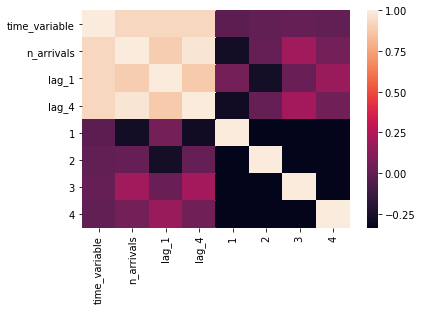

In [145]:
df_arrivals_nz_fummies = pd.merge(df_arrivals_nz[['time_variable', 'n_arrivals', 'lag_1', 'lag_4']], 
         pd.get_dummies(df_arrivals_nz['quarter']),
         right_index=True,
         left_index=True)

sns.heatmap(df_arrivals_nz_fummies.corr())

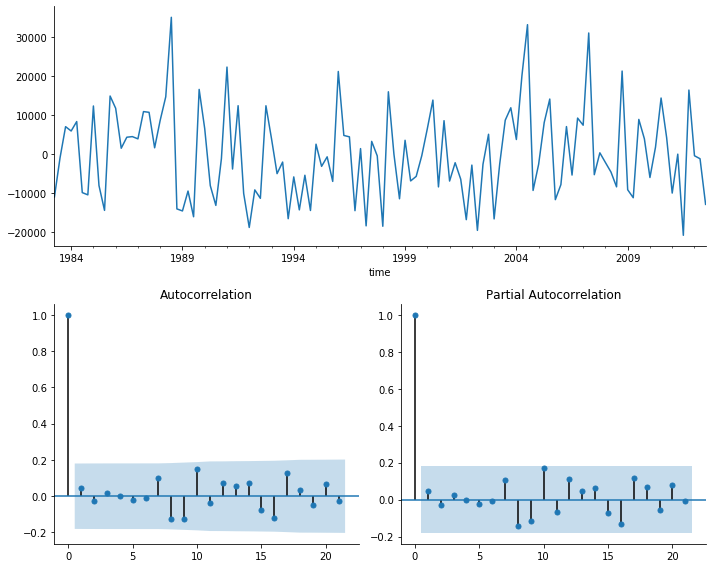

In [146]:
tsplot(model_arrivals_more_lags.resid);

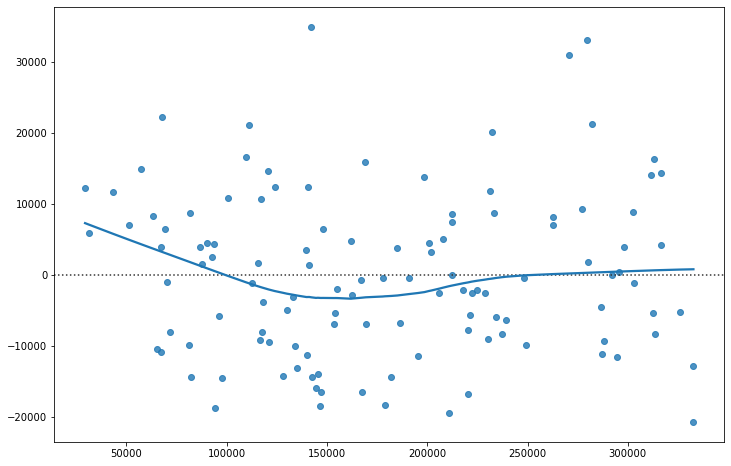

In [147]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x=model_arrivals_more_lags.fittedvalues.values, y=model_arrivals_more_lags.resid.values, lowess=True)

Again, we have improved our R2-Adj measurement as well as our residual plot does not look like so bad as before.

### Sample ACF and Properties of AR(1) Model

**Stationary Series**

For an ACF to make sense, we need to be sure our series is *weakly stationary*, ith fillowing properties:
- The mean E[x_t] is the same for all t.
- The variance of E[x_t] is the same for all t.
- The covariance (and also correlation) between x_t and x_t-1 is the same for all t.

**Autocorrelation Function (ACF)**

The correlation  between a point in time t and t-h, for h=1, 2, 3, 4, etc.

Defined as:

    Covariance(x_t, x_t_h) / Variance(x_t)

Following these guidelines, none of our series above are stationary, so we need to deal with trend and seasonality factors before plotting them. Note that residuals should by definition be stationary, since they must have constant mean (around 0) and constant variance, that is why we plotted their acf results.

Since our arrival dataset has seasonal and trend, let's decompose the serial based on additive model and then plot acf for residuals.

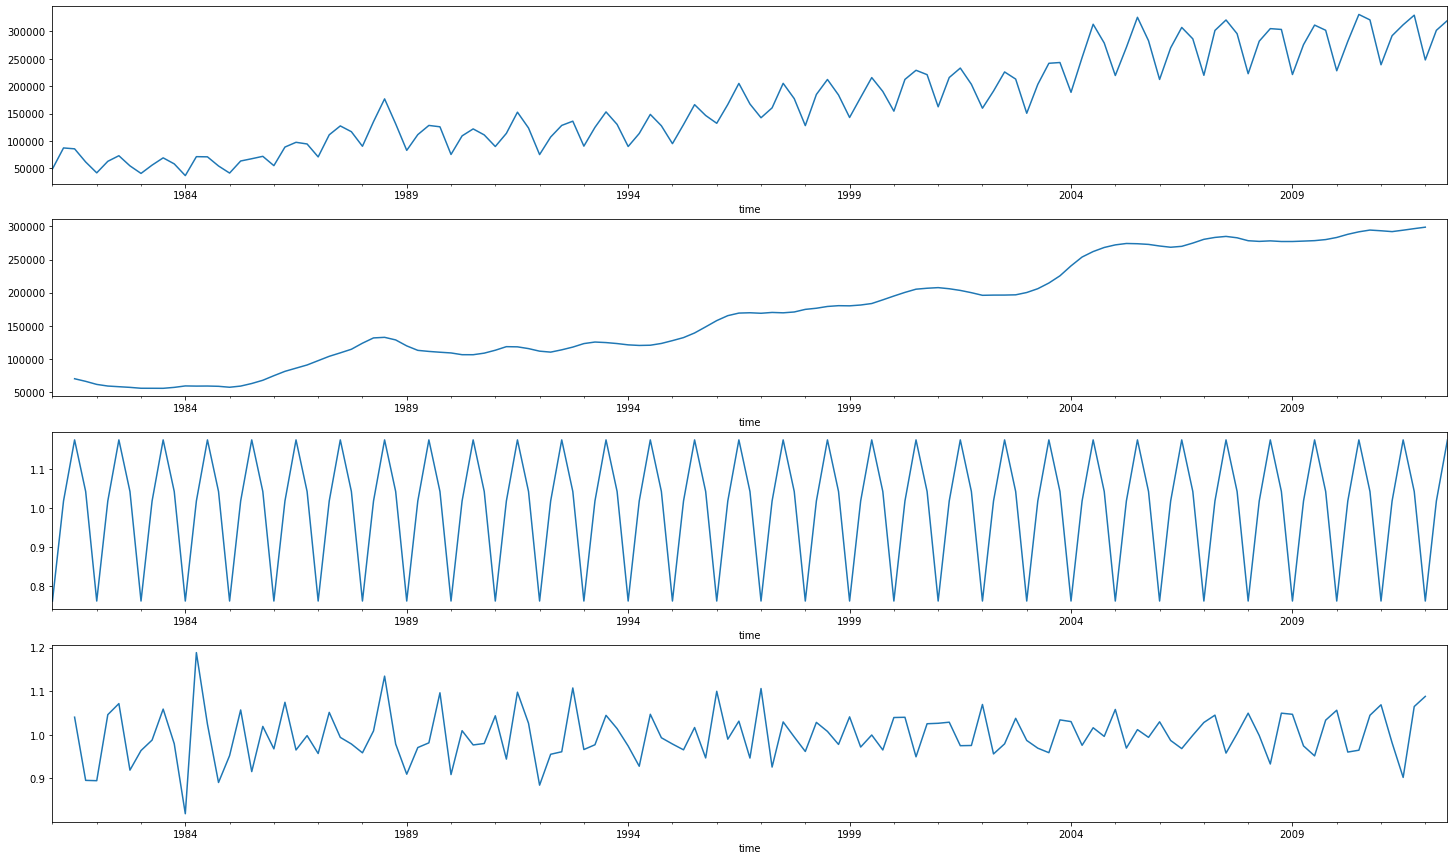

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decompose(series, model='additive', freq=None):

    fig, ax = plt.subplots(4, 1, figsize=(25, 15))

    result = seasonal_decompose(series, model=model, freq=freq)
    result.observed.plot(ax=ax[0])
    result.trend.plot(ax=ax[1])
    result.seasonal.plot(ax=ax[2])
    result.resid.plot(ax=ax[3])
    
    return result

df_arrivals_nz_decomposed = plot_seasonal_decompose(df_arrivals_nz['n_arrivals'], model='multiplicative')

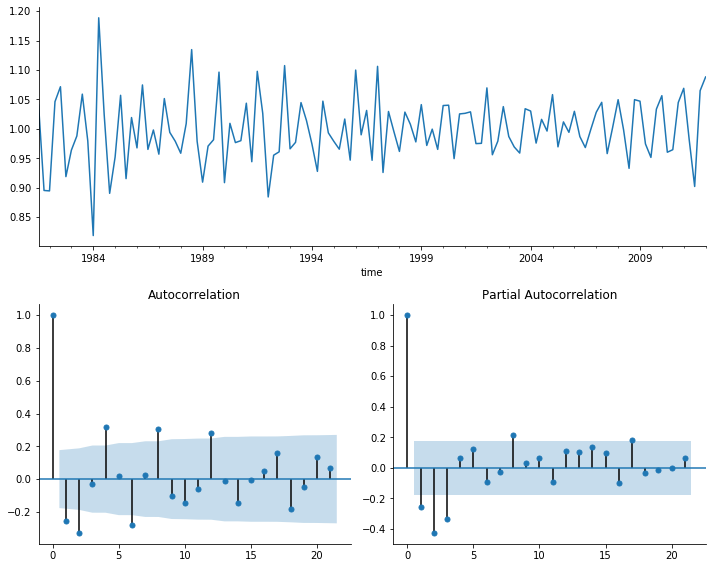

In [101]:
tsplot(df_arrivals_nz_decomposed.resid.dropna());

Same for climate data.

In [109]:
df_climate_sp = df_climate_sp.sort_index()

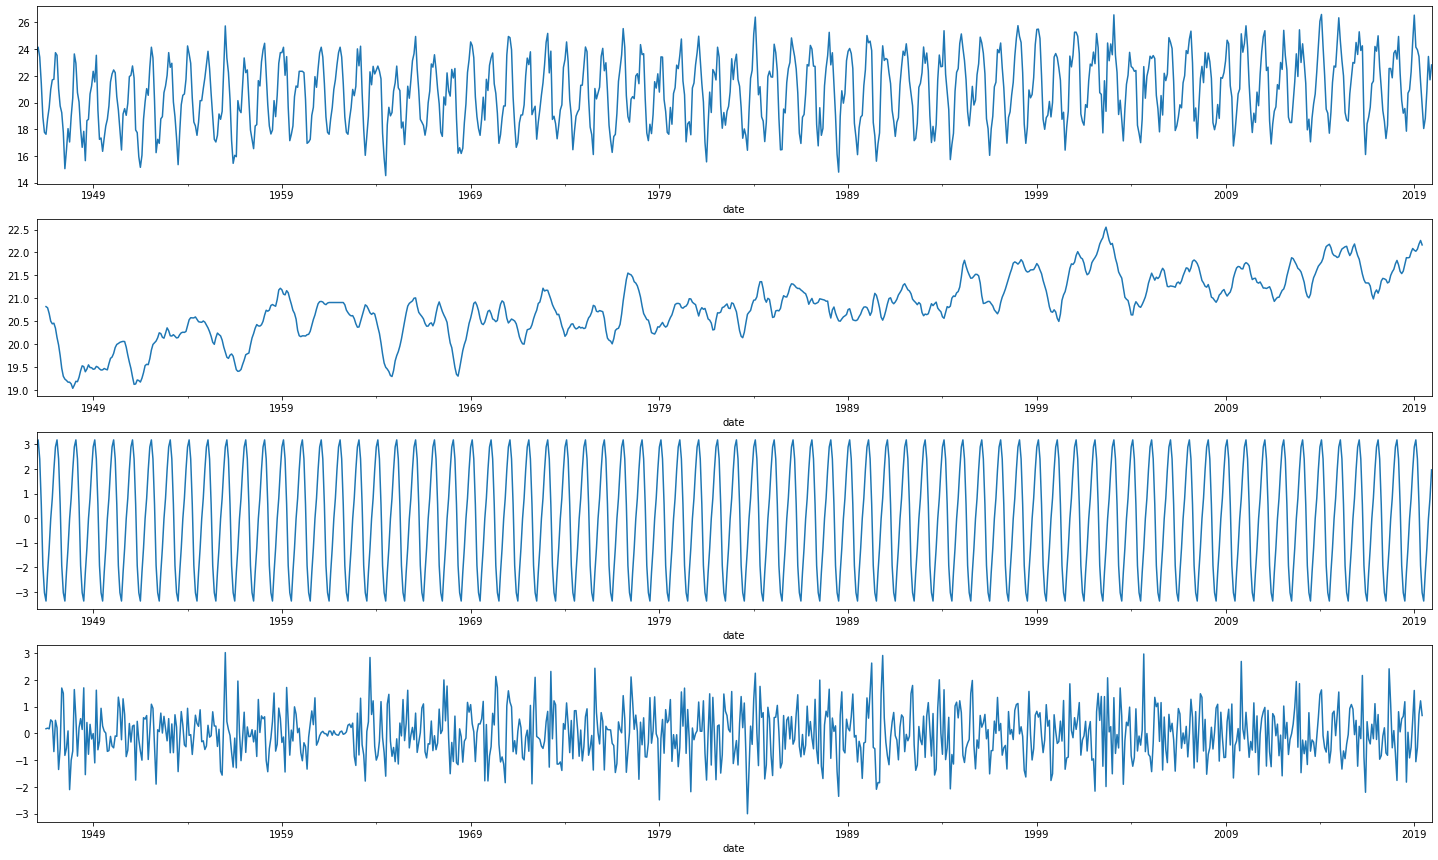

In [110]:
df_climate_sp_decomposed = plot_seasonal_decompose(df_climate_sp['temperature'], model='additive')

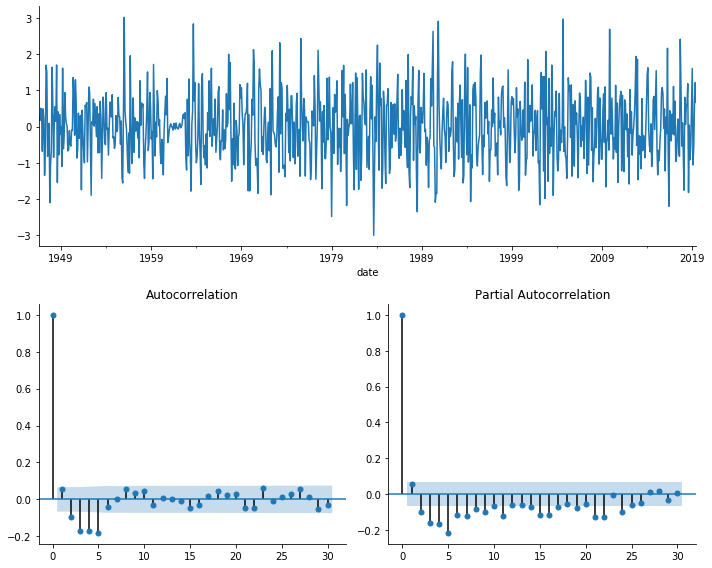

In [112]:
tsplot(df_climate_sp_decomposed.resid.dropna());

## Lesson 2: MA Models, Partial Autocorrelation, Notational Conventions

For an ARIMA model to be defined, we need to complete our studies learning more about MA terms. Remember that an autoregressive term is the variable of interest lagged by a specific time. For example, an AR(1) model is x_t lagged by 1 multiplied by a coefficient.

A **moving average** term in a time series model is a past error (multiplied by a coefficient).

For example, the first order moving average model, denoted by MA(1) is:

$x_{t} = \epsilon + w_{t} + \theta w_{t-1}  $
    
$w_{t} $ is an iid error term with N(0, $ \sigma^{2} $)

Let's create a MA(2) model. We need to create first a random variable, and then define our $ x_{t} $

In [156]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

wt = np.random.normal(size=1000)
df_wt = pd.Series(wt, name='wt').to_frame()

df_wt['wt_1'] = df_wt['wt'].shift(1).fillna(0)
df_wt['wt_2'] = df_wt['wt'].shift(2).fillna(0)
df_wt['x'] = 10 + df_wt['wt'] + 0.5*df_wt['wt_1'] + 0.3*df_wt['wt_2']

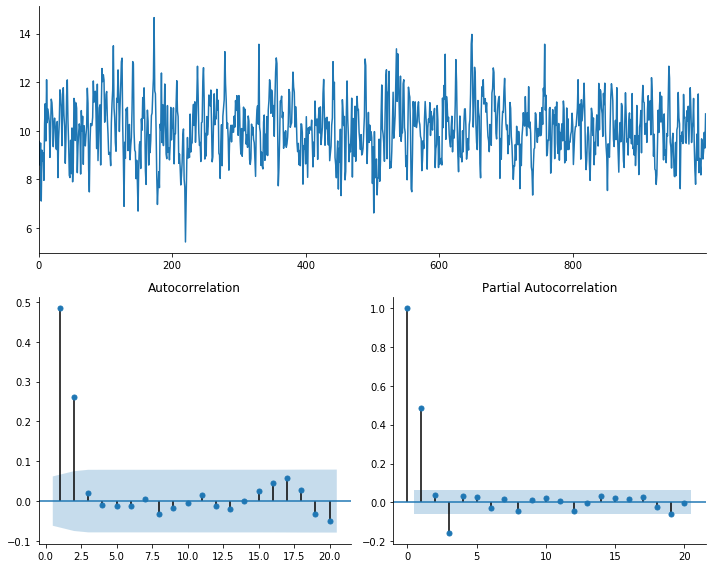

In [157]:
tsplot(df_wt['x'].dropna(), lags=20, zero=False);

### Partial Autocorrelation Function (PACF)

A PACF is a function which correlates two variables taking into account the influence that other set of variables have in the model. For example, let's ilustrate the concept with data.

First, let's define two random variable, $ x_{1}$, and $ x_{2} $.

In [148]:
x1 = np.random.normal(size=1000)
x2 = np.random.normal(size=1000)

Now, let's say we have a third predictor, $ x_{3}$, which has some correlation with $ x_{1}$ and $ x_{2}$.

In [149]:
x3 = 0.3*x1 + 0.1*x2 + np.random.normal(size=1000)

And, of course, we have a response variable y.

In [150]:
y = 0.2*x1-10*x2+3.4*x3+np.random.normal(size=1000)

Now, to calculate the true relationship between x3 and y, we have to eliminate the influence of x1 and x2. So we will first regress y on x1 and x2, and do the same for x3. Then, we will calculae the partial correlation, calculating the correlation between the residuals of these two regression models, so we can truly identify what x1 and x2 missed, and which x3 can be useful.

In [151]:
data = pd.DataFrame({'x1': x1,
                     'x2': x2,
                     'x3': x3,
                     'y': y})

lm = smf.ols("y ~ x1 + x2",
             data=data)
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     3981.
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:58:30   Log-Likelihood:                -2638.3
No. Observations:                1000   AIC:                             5283.
Df Residuals:                     997   BIC:                             5297.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1373      0.107     -1.280      0.201      -0.348       0.073
x1             1.3166      0.107     12.313      0.000       1.107       1.526
x2            -9.5070      0.109    -87.383      0.000      -9.720      -9.293
==============================================================================
Omnibus:                        0.280   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.183
Skew:                           0.011   Prob(JB):                        0.913
Kurtosis:                       3.062   Cond. No.                         1.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
lm = smf.ols("x3 ~ x1 + x2",
             data=data)
model_x3 = lm.fit()
model_x3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     x3   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     70.00
Date:                Sun, 01 Mar 2020   Prob (F-statistic):           3.58e-29
Time:                        10:58:31   Log-Likelihood:                -1367.2
No. Observations:                1000   AIC:                             2740.
Df Residuals:                     997   BIC:                             2755.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0574      0.030     -1.908      0.057      -0.116       0.002
x1             0.3293      0.030     10.975      0.000       0.270       0.388
x2             0.1565      0.031      5.128      0.000       0.097       0.216
==============================================================================
Omnibus:                        1.669   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.539
Skew:                          -0.065   Prob(JB):                        0.463
Kurtosis:                       3.141   Cond. No.                         1.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
np.cov(model.resid, model_x3.resid)/np.sqrt((np.var(model.resid)*np.var(model_x3.resid)))

array([[3.56801493, 0.95389524],
       [0.95389524, 0.28082926]])

We can see that the value for the coefficient of 3.56 is really close to the true one (3.4). Therefore, The PACF will correlate residuals, that is, it will explain the effect of one variable accounting for what the other ones could not do it.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f92c6806350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f92c6a6f4d0>)

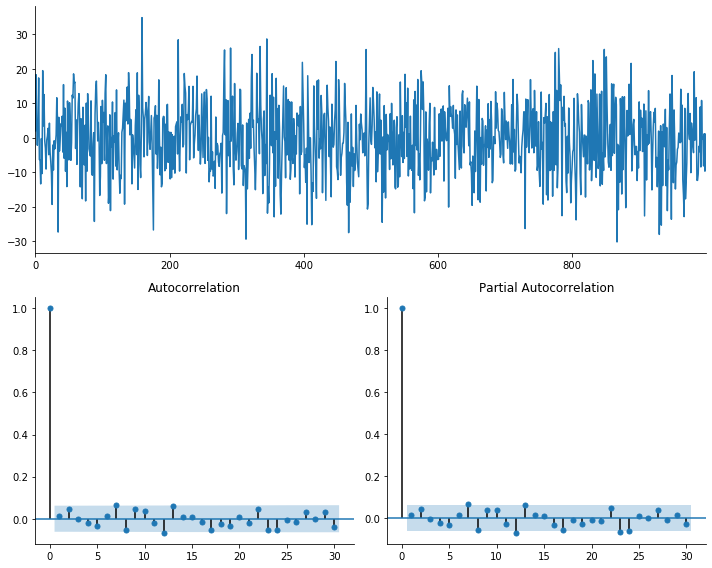

In [155]:
tsplot(pd.Series(y))

### Useful Facts about PACF and ACF Patterns

 - Identificaton of an AR model is often best done with the PACF function.
   - In practical terms, the number of non-zero partial autocorrelations gives the order of the AR model.
 - Identification of an MA model is often best done with the ACF rather than PACF.
   - The ACF will have non-zero autocorrelations only at lags involved in the model.